# Mathematical model parameter fitting : a data science case study

This Jupyter notebook is intended for new modelers to learn how to fit parameter values of their model to their data. 

However, if you're new to mathematical modeling this is the gist:

# Introduction

The type of mathematical modeling I'm referring to is a [system of ordinary differential equations](https://en.wikipedia.org/wiki/Ordinary_differential_equation). These models assess how a system (defined by non-linear interactions) changes over time. This type of modeling is used by the financial sector to predict [investment cycles](https://link.springer.com/article/10.1007/s10598-017-9371-4), by pharmaceutical companies [to predict if a preclinical drug will be effective](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5122624/), and by scientists trying to understand the susceptible-infection-recovery rates of [COVID-19](https://www.nature.com/articles/s41591-020-0883-7).

## Model definition

For this notebook, we will be looking at a really simple model. My background is in biology, so this will be a very simple [gene regulatory network](https://en.wikipedia.org/wiki/Gene_regulatory_network) model:

![gene_reg_network](./img/gene_reg_network.png)

where a signal activates ```Protein X``` with drives the transcription of ```Gene Y``` (shown by the black arrows). The gray dashed arrows indicate that both the protein and the gene are degraded over time. Note that there's a basal level of protein activation ($k_b$), and a [negative feedback loop](https://en.wikipedia.org/wiki/Negative_feedback) stemming from ```Gene Y``` supressing the ```Signal``` (at some rate $\beta$). The rates (hint, hint our parameters!) are defined next to each of the interactions. This model can be built from either the literature, your own hypotheses, or both!

Now, we can write this model as a system of ordinary differential equations:

$\frac{dX}{dt} = k_b + Signal - \beta * Y - d_1 * X$ 


$\frac{dY}{dt} = s_1 * X - d_2*Y$

Great! Now, let's say we recently collected some timeseries data for ```Gene Y``` that looks like this:

![synthetic data](./img/synth_data_5min.png)

## The problem: Can our model explain our data?

Now we need to fit our model to the data, meaning that we need to find optimal values for our parameters within the model. Sometimes these parameter values are known from real world measurements (like the rate of transcription), but let's just say we don't know the values to any of these 5 parameters ($k_b, \beta, d_1, s_1, d_2$ - remember ```X``` and ```Y``` are our model species and we know our ```Signal```).

Where do we start?

If you tried plugging in random values it could take you a lifetime to get a good fit. And until you do get a good fit, you'll be wondering whether or not you can rule this model out.

Let's use machine learning!

## Evolutionary Algorithm (EA):

The EA is a genetic algorithm that hones in on an optimal values/conditions based off of an error function. In this way, it will plug in a handful of initial random guesses, simulate your model with those parameters, assess how well those simulations do in comparison to the data (determined by your own error function), and then select the best scoring parameter set.

A diagram of of the EA works:

![title](img/EA2.png)

## IO

**Inputs**
- Experimental time-series data
- System of ordinary differential equations
- Range for parameter search space

**Output**
- Model Simulations
- Analysis

This notebook creates synthetic data, defines a basic model, and has ranges for the parameters already. Feel free to play around with them yourself!

# Housekeeping

## Import Packages

In [268]:
import matplotlib.pyplot as plt
import h5py
import pandas as pd

## Plotting settings

In [2]:
# plt.style.use("seaborn-whitegrid")
plt.rcParams['figure.figsize'] = [6, 4]

plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14

plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['grid.linestyle'] = '-'


plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10


green = '#228833'
blue = '#4477AA'

fig_folder = './Figs/'

## Import modules

In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(1, './modules')
from EA import *

from model import *

import plotting

## Model definition

### Model variables

In [198]:
dt = 0.1
steps = 251
time = np.linspace(0, dt*steps, steps)

sig = 5

X = 0
Y = 0
inits = [X, Y]

B = 1
kb = 0.1
s1 = 2
d1 = .5
d2 = .5
params = [B, kb, s1, d1, d2]

### Model definition

In [199]:
mod = model.Model(inits, time, model.m1)
sims = mod.run_simulation(params, sig)

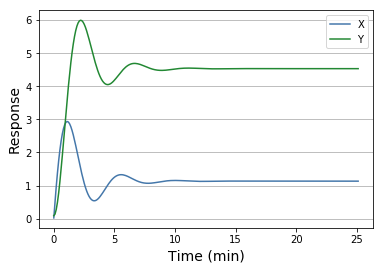

In [236]:
plt.plot(time, sims[:,0], color=blue, label = 'X')
plt.plot(time, sims[:,1], color=green, label = 'Y')
plt.xlabel('Time (min)')
plt.ylabel('Response')
plt.legend()
plt.show() 

## Load experimental data

### Create synth data

In [34]:
# synthetic data
def create_synth_data(species, interval, save_data):

    synth_time = range(0,26,interval)
    closest_idxs = [np.abs(time - t).argmin() for t in synth_time]
    synth_data = np.zeros((species.shape[1], len(closest_idxs)))

    for i, s in enumerate(species.T):
        synth_data[i] = s[closest_idxs]
        
    if save_data:
        ## TODO: add check if file exists
        with h5py.File("./Data/"+save_data+".hdf5", "w") as f:
            synth_data = f.create_dataset("response", data = synth_data)
            synth_time = f.create_dataset("time", data = synth_time)

#     return synth_time, synth_data


In [9]:
create_synth_data(sims, 1, save_data='synth_1min')
create_synth_data(sims, 5, save_data='synth_5min')

### Load synthetic data

In [12]:
synth_data_1min = h5py.File('./Data/synth_1min.hdf5', 'r')
synth_data_5min = h5py.File('./Data/synth_5min.hdf5', 'r')

Checking synthetic data

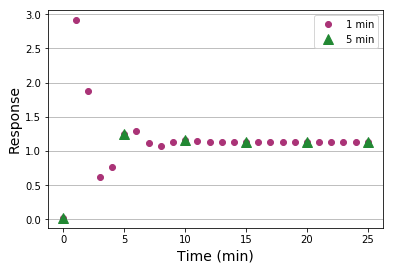

In [234]:
plt.plot(synth_data_1min['time'], synth_data_1min['response'][0], color = '#AA3377', marker='o', linestyle="None", label='1 min')
plt.plot(synth_data_5min['time'], synth_data_5min['response'][0], color = green, marker='^', linestyle="None", markersize=10, alpha=1, label='5 min')
plt.xlabel('Time (min)')
plt.ylabel('Response')
plt.legend()
plt.show() 

# Parameter Fitting with the EA

In [14]:
# Parameter ranges
minimums = [-2, -2, -2, -2, -2]
maximums = [2, 2, 2, 2, 2]

diff = np.asarray(maximums)-np.asarray(minimums) #for plotting
dims = (diff, minimums) #for plotting

labelnames = ['$B$','$k_b$','$s_1$','$d_1$','$d_2$']

species = [1]
sig = [5]

We'll use the synthetic data from ```Gene Y``` - 5 min data.

In [258]:
ea = EA(synth_data_5min, [0, 1], [5], mod, minimums, maximums, 10)
top_params, best_error = ea.run('./Simulation_data/Few_5min/')

0.0% complete.
10.0% complete.
20.0% complete.
30.0% complete.
40.0% complete.
50.0% complete.
60.0% complete.
70.0% complete.
80.0% complete.
90.0% complete.


In [259]:
synth_time = synth_data_5min['time']
synth_response = synth_data_5min['response']

## Load in simulation data

In [115]:
ea_5min = plotting.get_sim_data('./Simulation_data', num_sims=5)

Number of runs collected: 5
Number of sims without data: 0
2000


IndexError: list index out of range

## Check EA worked

In [260]:
def sort_sims(top_params, best_error, gen=-1):
    top_params_gen = np.array([top_params[i][gen] for i in range(len(top_params))])
    best_error_gen = np.array([best_error[i][gen] for i in range(len(best_error))])
    return top_params[np.argsort(best_error_gen)], best_error[np.argsort(best_error_gen)], top_params_gen[np.argsort(best_error_gen)], best_error_gen[np.argsort(best_error_gen)]

top_params_full, best_error_full, top_params_50g, best_error_50g  = sort_sims(top_params, best_error)

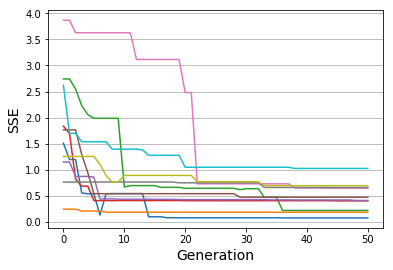

In [261]:
#plots the trajectory SSE over generations for the top 1% candidates
top1_error = best_error_full[:20]


for i in range(len(top1_error)):
    mses = top1_error[i]
    plt.plot(range(len(mses)), mses)
    
plt.xlabel('Generation')
plt.ylabel('SSE')
plt.show()

## Check simulation runs!

In [262]:
# run simulations for the parameters sets in the last generation

sim_data = []
closest_idxs = [np.abs(time - t).argmin() for t in synth_time]
for params in top_params_50g:
    sim_datum = mod.run_simulation(params, sig) 
    sim_data.append(sim_datum)

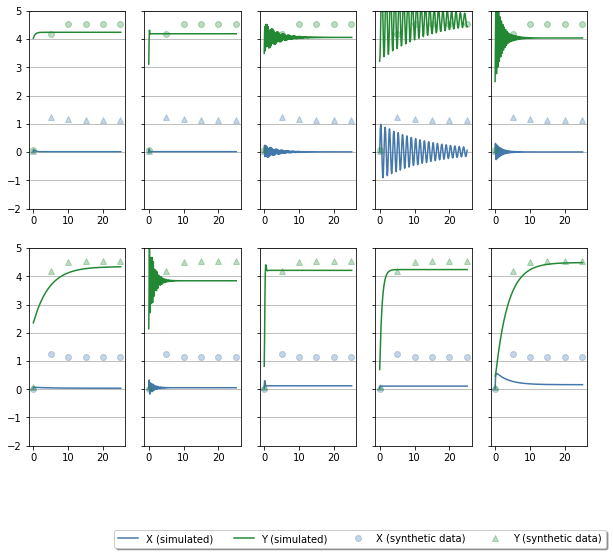

In [264]:
fig, axs = plt.subplots(2, 5, figsize=(10, 8), sharey=True)
for datum, i in zip(sim_data[:5], range(5)):
    axs[0,i].plot(time, datum[:,0], color=blue, label='X (simulated)')
    axs[0,i].plot(time, datum[:,1], color=green, label='Y (simulated)')
    axs[0,i].plot(synth_time, synth_response[0], color=blue, marker='^', linestyle="None", alpha=.3, label='Y (synthetic data)')
    axs[0,i].plot(synth_time, synth_response[1], color=green, marker='o', linestyle="None", alpha=.3, label='X (synthetic data)')


for datum, i in zip(sim_data[5:10], range(5)):
    axs[1,i].plot(time, datum[:,0], color=blue, label='X (simulated)')
    axs[1,i].plot(time, datum[:,1], color=green, label='Y (simulated)')
    axs[1,i].plot(synth_time, synth_response[0], color=blue, marker='o', linestyle="None", alpha=.3, label='X (synthetic data)')
    axs[1,i].plot(synth_time, synth_response[1], color=green, marker='^', linestyle="None", alpha=.3, label='Y (synthetic data)')

plt.legend(loc='upper right', bbox_to_anchor=(1.25, -0.40),
          fancybox=True, shadow=True, ncol=5)
plt.ylim(-2,5)
plt.show()



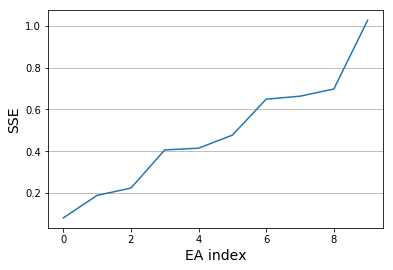

In [265]:
#plot last mse (generation 50) vs. index

plt.plot(range(len(best_error_50g)), best_error_50g)
plt.xlabel('EA index')
plt.ylabel('SSE')
plt.show()

ValueError: Length mismatch: Expected axis has 1 elements, new values have 5 elements

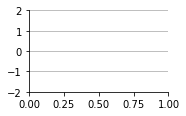

In [272]:
# see how close you are to the actual parameter values

num_plt = 100
df_plt = pd.DataFrame(top_params_50g[:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')

synth_data_df = pd.DataFrame(top_params_50g[:num_plt])
synth_data_df.columns = labelnames
synth_data_df_log = synth_data_df.apply(np.log10)

plotting.plt_param_ranges(labelnames, dims, top_params_50g, 100,  synth_data=synth_data_df_log) #black dot is best param


In [454]:
runs_sort[1][2]

array([1.0994688 , 0.1070828 , 1.33658255, 0.01048486, 3.27947906])

In [266]:
sse_params = []
for param in runs_sort[1]:
    sse = [np.absolute(x-p) for x, p in zip(var,param)]
    sse_params.append(sse)
    
# plt.plot(range(len(runs2)), sse_params)
plt.plot(range(len(runs))[:10], np.log(sse_params[:10]))
# plt.plot(range(len(runs))[:10], sse_params[:10])
plt.legend(labelnames)
# plt.plot(range(len(runs))[:5], np.log([(x-p)**2 for x, p in zip(var,var)]))

NameError: name 'runs_sort' is not defined

## Runs to 5 min interval, both Y and X

In [376]:
runs4 = run([Y_data_synth], [X_data_synth],synth_time)

0.0% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


10.0% complete.
20.0% complete.
30.0% complete.
40.0% complete.
50.0% complete.
60.0% complete.
70.0% complete.
80.0% complete.
90.0% complete.


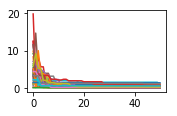

In [377]:
for i in range(len(runs)):
    mses = runs4[i][0]
    plt.plot(range(len(mses)), mses)

In [378]:
sim_data4 = []
closest_idxs = [np.abs(time - t).argmin() for t in synth_time]
runs_sort4 = sort_sims(runs4)
for param in runs_sort4[1]:
    ss_inits = run_ss(model, inits, param)
    sim_datum = run_experiment(model, ss_inits, time, param, sig) 
#     sim_datum2 = run_experiment(model, ss_inits, time, param, sig)
    sim_data4.append(sim_datum)

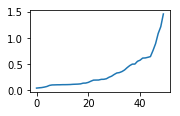

In [379]:
plt.plot(range(len(runs)), runs_sort4[0])

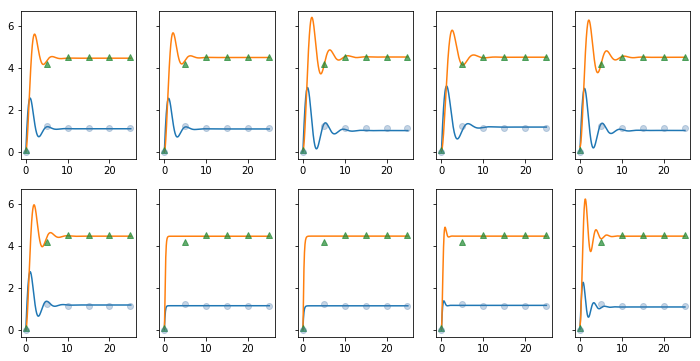

In [654]:
fig, axs = plt.subplots(2, 5, figsize=(12, 6), sharey=True)
for datum, i in zip(sim_data4[:5], range(5)):
    axs[0,i].plot(time, datum)
    axs[0,i].plot(synth_time, Y_data_synth, color=green, marker='^', linestyle="None", alpha=.7)
    axs[0,i].plot(synth_time, X_data_synth, color=blue, marker='o', linestyle="None", alpha=.3)
for datum, i in zip(sim_data4[5:], range(5)):
    axs[1,i].plot(time, datum)
    axs[1,i].plot(synth_time, Y_data_synth, color=green, marker='^', linestyle="None", alpha=.7)
    axs[1,i].plot(synth_time, X_data_synth, color=blue, marker='o', linestyle="None", alpha=.3)


   $B$  $k_b$    $s_1$    $d_1$    $d_2$
0  0.0   -1.0  0.30103 -0.30103 -0.30103


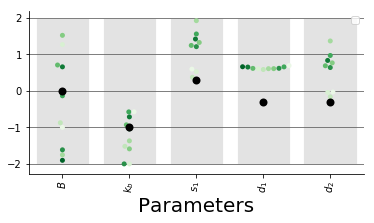

In [372]:
num_plt = 100
df_plt = pd.DataFrame(runs_sort4[1][:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')

synth_data_df = pd.DataFrame(var).T
synth_data_df.columns = labelnames
synth_data_df_log = synth_data_df.apply(np.log10)

plt_param_ranges(labelnames, dims, runs_sort4, 10,  synth_data=synth_data_df_log) #black dot is best param


## Runs to 1 min interval, just Y

In [345]:
runs2 = run([Y_data_synth2], synth_time2)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


KeyboardInterrupt: 

In [335]:
sim_data2 = []

runs_sort2 = sort_sims(runs2)

for param in runs_sort2[1]:
    ss_inits = run_ss(model, inits, param)
    sim_datum = run_experiment(model, ss_inits, time, param, sig) 
    sim_data2.append(sim_datum)

(array([ 4.,  4.,  7.,  3.,  5., 12.,  5.,  7.,  1.,  2.]),
 array([0.01994355, 0.0426136 , 0.06528365, 0.0879537 , 0.11062375,
        0.1332938 , 0.15596385, 0.1786339 , 0.20130394, 0.22397399,
        0.24664404]),
 <a list of 10 Patch objects>)

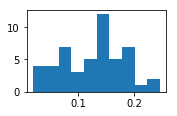

In [337]:
plt.hist(runs_sort2[0])

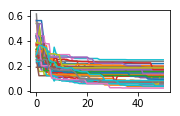

In [425]:
for i in range(len(runs2)):
    mses = runs2[i][0]
    plt.plot(range(len(mses)), mses)
plt.savefig(fig_folder+'6B.jpg', dpi=300,bbox_inches='tight')   

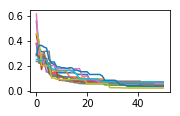

In [424]:
for i in range(len(runs2)):
    mses = runs2[i][0]
    if mses[-1] <= runs_sort2[0][10]:
        plt.plot(range(len(mses)), mses)
plt.savefig(fig_folder+'6Bi.jpg', dpi=300,bbox_inches='tight')    

   $B$  $k_b$    $s_1$    $d_1$    $d_2$
0  0.0   -1.0  0.30103 -0.30103 -0.30103


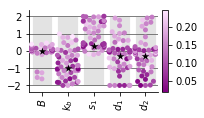

In [514]:
# use
# df_top_thetas_EA = pd.DataFrame(runs_sort2[1])
# df_top_thetas_EA.columns = labelnames

num_plt = 100
df_plt = pd.DataFrame(runs_sort2[1][:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')

synth_data_df = pd.DataFrame(var).T
synth_data_df.columns = labelnames
synth_data_df_log = synth_data_df.apply(np.log10)


plt_param_ranges(labelnames, dims, runs_sort2, 100,  synth_data=synth_data_df_log, save_fig='6C.jpg') #black dot is best param

   $B$  $k_b$    $s_1$    $d_1$    $d_2$
0  0.0   -1.0  0.30103 -0.30103 -0.30103


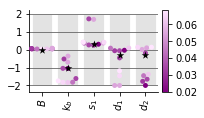

In [515]:
num_plt = 10
df_plt = pd.DataFrame(runs_sort2[1][:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')

synth_data_df = pd.DataFrame(var).T
synth_data_df.columns = labelnames
synth_data_df_log = synth_data_df.apply(np.log10)


plt_param_ranges(labelnames, dims, runs_sort2, 10,  synth_data=synth_data_df_log, save_fig='6Ci.jpg') #black dot is best param
# plt.savefig(fig_folder+'6Ci.jpg', dpi=300,bbox_inches='tight')   

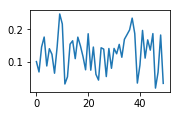

In [339]:
plt.plot(range(len(runs2)), [runs2[i][0][-1] for i in range(len(runs2))])

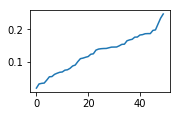

In [340]:
plt.plot(range(len(runs2)), runs_sort2[0])

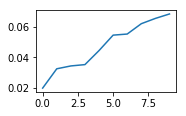

In [341]:
plt.plot(range(len(runs2[:10])), runs_sort2[0][:10])

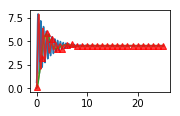

In [342]:
for datum in sim_data2[11:15]:
    plt.plot(time, datum[:,1])
    plt.plot(synth_time2, Y_data_synth2, color='red', marker='^', linestyle="None", alpha=.3)
#     pltplot(synth_time2, X_data_synth2, color='blue', marker='o', linestyle="None", alpha=.3)

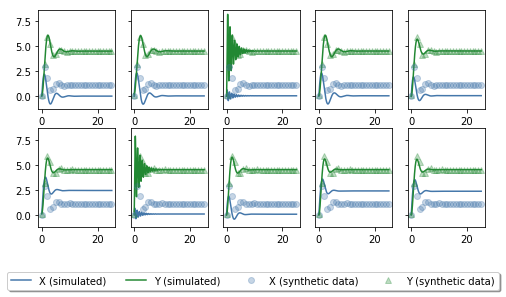

In [502]:
fig, axs = plt.subplots(2, 5, figsize=(8, 4), sharey=True)
for datum, i in zip(sim_data2[:5], range(5)):
    axs[0,i].plot(time, datum[:,0], color=blue, label='X (simulated)')
    axs[0,i].plot(time, datum[:,1], color=green, label='Y (simulated)')
    axs[0,i].plot(synth_time2, Y_data_synth2, color=green, marker='^', linestyle="None", alpha=.3, label='Y (synthetic data)')
    axs[0,i].plot(synth_time2, X_data_synth2, color=blue, marker='o', linestyle="None", alpha=.3, label='X (synthetic data)')


for datum, i in zip(sim_data2[5:10], range(5)):
    axs[1,i].plot(time, datum[:,0], color=blue, label='X (simulated)')
    axs[1,i].plot(time, datum[:,1], color=green, label='Y (simulated)')
    axs[1,i].plot(synth_time2, X_data_synth2, color=blue, marker='o', linestyle="None", alpha=.3, label='X (synthetic data)')
    axs[1,i].plot(synth_time2, Y_data_synth2, color=green, marker='^', linestyle="None", alpha=.3, label='Y (synthetic data)')

plt.legend(loc='upper right', bbox_to_anchor=(1.25, -0.40),
          fancybox=True, shadow=True, ncol=5)


plt.savefig(fig_folder+'7B.jpg', dpi=300,bbox_inches='tight')

   $B$  $k_b$    $s_1$    $d_1$    $d_2$
0  0.0   -1.0  0.30103 -0.30103 -0.30103


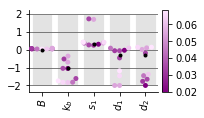

In [503]:
# use
# df_top_thetas_EA = pd.DataFrame(runs_sort2[1])
# df_top_thetas_EA.columns = labelnames

num_plt = 100
df_plt = pd.DataFrame(runs_sort2[1][:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')

synth_data_df = pd.DataFrame(var).T
synth_data_df.columns = labelnames
synth_data_df_log = synth_data_df.apply(np.log10)


plt_param_ranges(labelnames, dims, runs_sort2, 10,  synth_data=synth_data_df_log) #black dot is best param
# plt.savefig(fig_folder+'5B3.jpg', dpi=300,bbox_inches='tight')

(-3, 3)

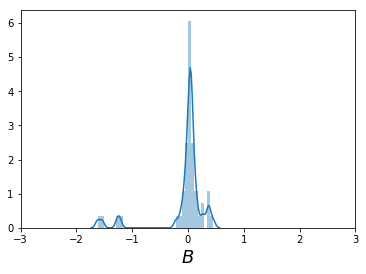

In [506]:

# use
sns.distplot(df_plt_log[labelnames[0]])
plt.xlim(-3,3)

(-3, 3)

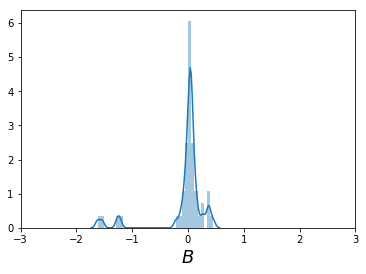

In [507]:
# use
sns.distplot(df_plt_log[labelnames[0]])
plt.xlim(-3,3)

In [526]:
param_mses = []

for param in runs_sort2[1][:10]:
    diff = np.sum(np.absolute(param-var))
    param_mses.append(diff)
# 1/0
print(np.argmin(param_mses))
print(param_mses)

0
[1.0491461854179596, 1.4507140217057608, 50.742014256381125, 1.1406254016008557, 1.6416753644804385, 1.8185269045942216, 48.511816842475135, 1.9472956180802703, 2.0931909258940387, 2.0705112899720923]


3
[31.377279178907465, 29.83636624431907, 35.0779595641009, 29.161145017265614, 29.428621327773307, 43.16608144789633, 33.35281024570025, 30.29595804126305, 40.311495211454826, 38.441391761605765]


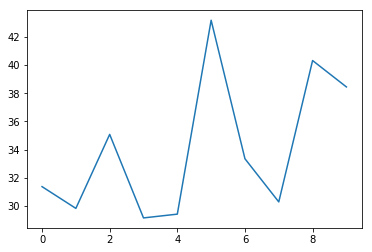

In [528]:
# use
# x and y species' MSES

mses_YX = []
for param in runs_sort2[1]:
    mses_YX.append(scorefxn2(param, [Y_data_synth2], [X_data_synth2], synth_time2, convert=False))
    
# plt.plot(range(len(runs2)), mses_YX)

plt.plot(range(len(runs2))[:10], mses_YX[:10])

print(np.argmin(mses_YX[:10]))
print(mses_YX[:10])

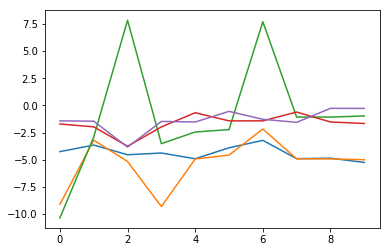

In [518]:
# use
##sum of squared errors for each parameter set, log 

sse_params = []
for param in runs_sort2[1]:
    sse = [(x-p)**2 for x, p in zip(var,param)]
    sse_params.append(sse)
    
# plt.plot(range(len(runs2)), sse_params)
plt.plot(range(len(runs2))[:10], np.log(sse_params))



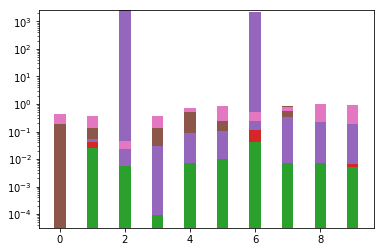

In [519]:
sse_params_arr = np.array(sse_params[:10])

N = 10
n1 = sse_params_arr[:,0]
n2 = sse_params_arr[:,1]
# menStd = (2, 3, 4, 1, 2)
# womenStd = (3, 5, 2, 3, 3)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, n1, width)
p2 = plt.bar(ind, n2, width,
             bottom=n1)

plt.bar(ind, sse_params_arr[:,0], width)
for i in range(1,5):
    n = sse_params_arr[:,i]
    plt.bar(ind, n, width,
             bottom=sse_params_arr[:,i-1])
    
plt.yscale('log')
# plt.ylabel('Scores')
# plt.title('Scores by group and gender')
# plt.xticks(ind, ('G1', 'G2', 'G3', 'G4', 'G5'))
# plt.yticks(np.arange(0, 81, 10))
# plt.legend((p1[0], p2[0]), ('Men', 'Women'))

plt.show()

## Runs to 1 min interval, both Y and X

In [381]:
runs3 = run([Y_data_synth2], [X_data_synth2], synth_time2)

0.0% complete.
10.0% complete.


C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


20.0% complete.
30.0% complete.
40.0% complete.
50.0% complete.
60.0% complete.
70.0% complete.
80.0% complete.
90.0% complete.


In [382]:
sim_data3 = []

runs_sort3 = sort_sims(runs3)

for param in runs_sort3[1]:
    ss_inits = run_ss(model, inits, param)
    sim_datum = run_experiment(model, ss_inits, time, param, sig) 
    sim_data3.append(sim_datum)

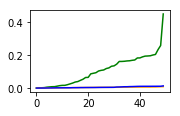

In [383]:
##sse  / # datapoints <- incorrect

plt.plot(range(len(runs3)), runs_sort3[0]/len(Y_data_synth2)/2, color='green')
plt.plot(range(len(runs3)), runs_sort2[0]/len(Y_data_synth2), color='orange')
plt.plot(range(len(runs3)), runs_sort[0]/len(Y_data_synth), color='blue')

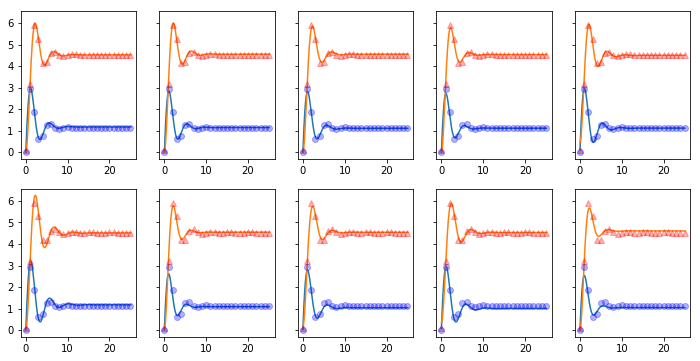

In [384]:
fig, axs = plt.subplots(2, 5, figsize=(12, 6), sharey=True)
for datum, i in zip(sim_data3[:5], range(5)):
    axs[0,i].plot(time, datum)
    axs[0,i].plot(synth_time2, Y_data_synth2, color='red', marker='^', linestyle="None", alpha=.3)
    axs[0,i].plot(synth_time2, X_data_synth2, color='blue', marker='o', linestyle="None", alpha=.3)
for datum, i in zip(sim_data3[5:10], range(5)):
    axs[1,i].plot(time, datum)
    axs[1,i].plot(synth_time2, Y_data_synth2, color='red', marker='^', linestyle="None", alpha=.3)
    axs[1,i].plot(synth_time2, X_data_synth2, color='blue', marker='o', linestyle="None", alpha=.3)

   $B$  $k_b$    $s_1$    $d_1$    $d_2$
0  0.0   -1.0  0.30103 -0.30103 -0.30103


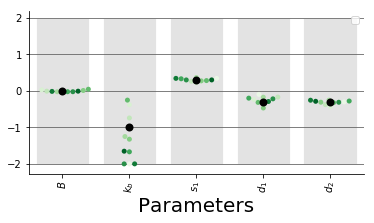

In [385]:
# use
# df_top_thetas_EA = pd.DataFrame(runs_sort2[1])
# df_top_thetas_EA.columns = labelnames

num_plt = 100
df_plt = pd.DataFrame(runs_sort3[1][:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')

synth_data_df = pd.DataFrame(var).T
synth_data_df.columns = labelnames
synth_data_df_log = synth_data_df.apply(np.log10)


plt_param_ranges(labelnames, dims, runs_sort3, 10,  synth_data=synth_data_df_log) #black dot is best param


In [541]:
error1 =[]
for param in runs_sort[1]:
    error = scorefxn1(param, [Y_data_synth], synth_time)
    error1.append(error)
    
error2 =[]
for param in runs_sort2[1]:
    error = scorefxn1(param, [Y_data_synth2], synth_time2)
    error2.append(error)
    
error3 =[]
for param in runs_sort3[1]:
    error = scorefxn2(param, [Y_data_synth2],[X_data_synth2], synth_time2)
    error3.append(error)
    
error4 =[]
for param in runs_sort4[1]:
    error = scorefxn2(param, [Y_data_synth],[X_data_synth], synth_time)
    error4.append(error)

In [420]:
test = np.sort(error1)
print(test)

[0.00317052 0.00502865 0.00610948 0.00775615 0.00896865 0.00899498
 0.00900863 0.00902675 0.0101765  0.01100307 0.01196153 0.01199275
 0.01219195 0.0128505  0.01329926 0.01485445 0.01844714 0.01901084
 0.01940497 0.02186576 0.02211392 0.02212233 0.02262288 0.02473797
 0.02605512 0.02668924 0.02715334 0.03018561 0.03162048 0.03958447
 0.04815865 0.04879756 0.05219525 0.05410872 0.05493332 0.06348489
 0.0647494  0.06800943 0.07312693 0.0755553  0.08012572 0.08438029
 0.0920454  0.09359578 0.09405417 0.09562606 0.09601334 0.09645201
 0.09773614 0.11049081]


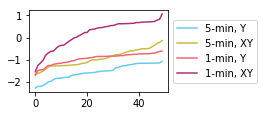

In [550]:
#use
plt.plot(range(len(runs3)), np.log10(np.sort(error1)), color='#66ccee',label='5-min, Y') #5 min
plt.plot(range(len(runs3)), np.log10(np.sort(error4)/2), color='#ccbb44',label='5-min, XY') #10 min both YX
plt.plot(range(len(runs3)), np.log10(np.sort(error2)), color='#ee6677',label='1-min, Y')#1 min just Y
plt.plot(range(len(runs3)), np.log10(np.sort(error3)/2), color='#aa3377',label='1-min, XY') #1 min both YX

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.savefig(fig_folder+'8C.jpg', dpi=300,bbox_inches='tight')

# model no neg

In [553]:
def model2(inits, t, var, sig):
    X, Y = inits 
    B, kb, s1, d1, d2 = var
       
    
    dX = kb + sig - d1 * X
    dY = s1 * X - d2*Y  # * (Y_t-Y)
     
    return dX, dY

In [35]:
runs_noneg = run([Y_data_synth], [X_data_synth],synth_time)

C:\Users\sksuzuki\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


0.0% complete.
10.0% complete.
20.0% complete.
30.0% complete.
40.0% complete.
50.0% complete.
60.0% complete.
70.0% complete.
80.0% complete.
90.0% complete.


In [554]:
sim_data_nn = []

runs_sort_nn = sort_sims(runs_noneg)

for param in runs_sort_nn[1]:
    ss_inits = run_ss(model2, inits, param)
    sim_datum = run_experiment(model2, ss_inits, time, param, sig) 
    sim_data_nn.append(sim_datum)

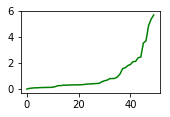

In [555]:
plt.plot(range(len(runs_noneg)), runs_sort_nn[0], color='green')


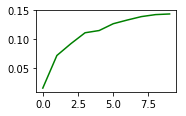

In [556]:
plt.plot(range(len(runs_noneg))[:10], runs_sort_nn[0][:10], color='green')


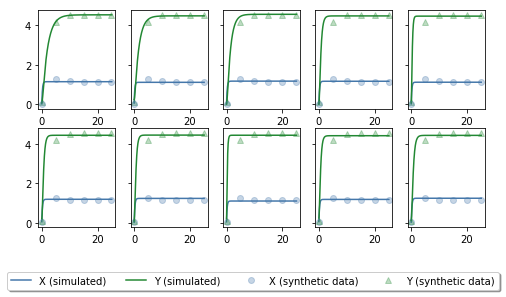

In [558]:
fig, axs = plt.subplots(2, 5, figsize=(8, 4), sharey=True)
for datum, i in zip(sim_data_nn[:5], range(5)):
    axs[0,i].plot(time, datum[:,0], color=blue, label='X (simulated)')
    axs[0,i].plot(time, datum[:,1], color=green, label='Y (simulated)')
    axs[0,i].plot(synth_time, Y_data_synth, color=green, marker='^', linestyle="None", alpha=.3, label='Y (synthetic data)')
    axs[0,i].plot(synth_time, X_data_synth, color=blue, marker='o', linestyle="None", alpha=.3, label='X (synthetic data)')


for datum, i in zip(sim_data_nn[5:10], range(5)):
    axs[1,i].plot(time, datum[:,0], color=blue, label='X (simulated)')
    axs[1,i].plot(time, datum[:,1], color=green, label='Y (simulated)')
    axs[1,i].plot(synth_time, X_data_synth, color=blue, marker='o', linestyle="None", alpha=.3, label='X (synthetic data)')
    axs[1,i].plot(synth_time, Y_data_synth, color=green, marker='^', linestyle="None", alpha=.3, label='Y (synthetic data)')

plt.legend(loc='upper right', bbox_to_anchor=(1.25, -0.40),
          fancybox=True, shadow=True, ncol=5)


plt.savefig(fig_folder+'9.jpg', dpi=300,bbox_inches='tight')

   $B$  $k_b$    $s_1$    $d_1$    $d_2$
0  0.0   -1.0  0.30103 -0.30103 -0.30103


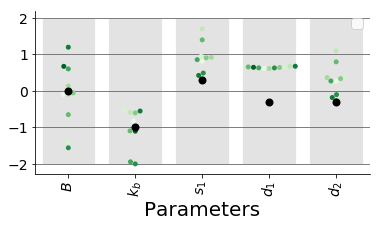

In [42]:
# use
# df_top_thetas_EA = pd.DataFrame(runs_sort2[1])
# df_top_thetas_EA.columns = labelnames

num_plt = 100
df_plt = pd.DataFrame(runs_sort_nn[1][:num_plt])
df_plt.columns = labelnames
df_plt_log = df_plt.apply(np.log10)
df_plt_log_M = df_plt_log.melt(var_name='param', value_name='vals')

synth_data_df = pd.DataFrame(var).T
synth_data_df.columns = labelnames
synth_data_df_log = synth_data_df.apply(np.log10)


plt_param_ranges(labelnames, dims, runs_sort_nn, 10,  synth_data=synth_data_df_log) #black dot is best param


In [107]:
fp = []

def find_fixed_points(r):
    for x in range(r):
        for y in range(r):
            if ((f(x,y) == 0) and (g(x,y) == 0)):
                fp.append((x,y))
                print('The system has a fixed point in %s,%s' % (x,y))
    return fp

find_fixed_points(5001)

[]

# Model driven experimental design

In [660]:
def model(inits, t, var, sig):
    X, Y = inits 
    B, kb, s1, d1, d2 = var
    d2 = 0
    if t > 0:
        sig = 5
    if t > 10:
        sig = 0
    if t > 20:
        sig = 5
        
    dX = kb + sig - B * Y - d1 * X
    dY = s1 * X - d2*Y  # * (Y_t-Y)
     
    return dX, dY


def model2(inits, t, var, sig):
    X, Y = inits 
    B, kb, s1, d1, d2 = var
#     d2 = 0

    if t > 0:
        sig = 5
    if t > 10:
        sig = 0
    if t > 20:
        sig = 5
    
    dX = kb + sig - d1 * X
    dY = s1 * X - d2*Y  # * (Y_t-Y)
     
    return dX, dY

In [563]:
null_model_params = runs_sort_nn[1][0]
true_model_params = runs_sort4[1][0]

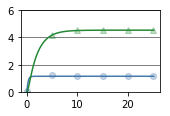

In [658]:
ninits = run_ss(model, [0,0], param)
ndatum = run_experiment(model2, ninits, time, null_model_params, sig) 

plt.plot(time, ndatum[:,0], color=blue, label='X')
plt.plot(time, ndatum[:,1], color=green, label='Y')

plt.plot(synth_time, X_data_synth, color=blue, marker='o', linestyle="None", alpha=.3, label='X (synthetic data)')
plt.plot(synth_time, Y_data_synth, color=green, marker='^', linestyle="None", alpha=.3, label='Y (synthetic data)')

plt.ylim(0, 6)
plt.grid(color='#606060', which='major', axis='y', linestyle='solid')

# plt.savefig(fig_folder+'101.jpg', dpi=300,bbox_inches='tight')

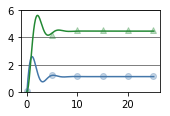

In [659]:
trinits = run_ss(model, [0,0], param)
trdatum = run_experiment(model, trinits, time, true_model_params, sig) 

plt.plot(time, trdatum[:,0], color=blue, label='X')
plt.plot(time, trdatum[:,1], color=green, label='Y')

plt.plot(synth_time, X_data_synth, color=blue, marker='o', linestyle="None", alpha=.3, label='X (synthetic data)')
plt.plot(synth_time, Y_data_synth, color=green, marker='^', linestyle="None", alpha=.3, label='Y (synthetic data)')

plt.ylim(0, 6)
plt.grid(color='#606060', which='major', axis='y', linestyle='solid')

# plt.savefig(fig_folder+'102.jpg', dpi=300,bbox_inches='tight')

## Different inits

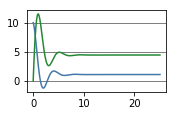

In [637]:
tdatum = run_experiment(model, [10,0], time, true_model_params, sig) 
# print(tdatum)
plt.plot(time, tdatum[:,0], color=blue, label='X')
plt.plot(time, tdatum[:,1], color=green, label='Y')
plt.grid(color='#606060', which='major', axis='y', linestyle='solid')

# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# plt.savefig(fig_folder+'10ab.jpg', dpi=300,bbox_inches='tight')

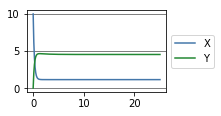

In [636]:
# tinits = run_ss(model2, [100,100], param)
tdatum = run_experiment(model2, [10,0], time, null_model_params, sig) 
# print(tdatum)
plt.plot(time, tdatum[:,0], color=blue, label='X')
plt.plot(time, tdatum[:,1], color=green, label='Y')
plt.grid(color='#606060', which='major', axis='y', linestyle='solid')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig(fig_folder+'10a1.jpg', dpi=300,bbox_inches='tight')

## Different input

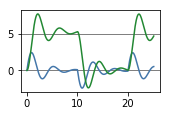

In [661]:
t2inits = run_ss(model, [0,0], param)
t2datum = run_experiment(model, t2inits, time, true_model_params, sig) 
# print(tdatum)
plt.plot(time, t2datum[:,0], color=blue, label='X')
plt.plot(time, t2datum[:,1], color=green, label='Y')

# plt.ylim(-2, 6)
plt.grid(color='#606060', which='major', axis='y', linestyle='solid')

# plt.savefig(fig_folder+'10b1.jpg', dpi=300,bbox_inches='tight')

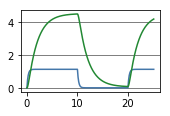

In [662]:
t2inits = run_ss(model, [0,0], param)
t2datum = run_experiment(model2, t2inits, time, null_model_params, sig) 
# print(tdatum)
plt.plot(time, t2datum[:,0], color=blue, label='X')
plt.plot(time, t2datum[:,1], color=green, label='Y')

# plt.ylim(-2, 6)
plt.grid(color='#606060', which='major', axis='y', linestyle='solid')

# plt.savefig(fig_folder+'10b2.jpg', dpi=300,bbox_inches='tight')

## Different structures

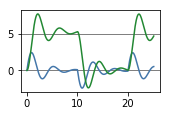

In [663]:
t2inits = run_ss(model, [0,0], param)
t2datum = run_experiment(model, t2inits, time, true_model_params, sig) 
# print(tdatum)
plt.plot(time, t2datum[:,0], color=blue, label='X')
plt.plot(time, t2datum[:,1], color=green, label='Y')

# plt.ylim(-2, 6)
plt.grid(color='#606060', which='major', axis='y', linestyle='solid')

# plt.savefig(fig_folder+'10c1.jpg', dpi=300,bbox_inches='tight')

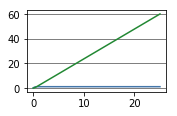

In [616]:
t2inits = run_ss(model, [0,0], param)
t2datum = run_experiment(model2, t2inits, time, null_model_params, sig) 
# print(tdatum)
plt.plot(time, t2datum[:,0], color=blue, label='X')
plt.plot(time, t2datum[:,1], color=green, label='Y')

# plt.ylim(-2, 6)
plt.grid(color='#606060', which='major', axis='y', linestyle='solid')

# plt.savefig(fig_folder+'10c2.jpg', dpi=300,bbox_inches='tight')